# This simple strategy based on daily candles works well on high violatility products such as SPXL and TQQQ

*   backtested on TQQQ >2000% returns from 2020 to 2025
*   backtested on SPXL >700% returns from 2020 to 2025
*   outperforms buy & hold on multiple tickers

# Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from IPython.display import display


# Initialize Ticker, Date range and IBS rules


In [ ]:
def import_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data = pd.DataFrame(data)
    data["IBS"] = (data["Close"] - data["Low"]) / (data["High"] - data["Low"]) # Compute IBS
    return data

ticker = "TQQQ"
start_date = "2020-01-01"
end_date = "2025-12-31"

data = import_data(ticker, start_date, end_date)

# Strategy rules
entry_threshold = 0.19
exit_threshold = 0.95

display(data.head())

/tmp/ipython-input-16-2141501908.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,IBS
Ticker,TQQQ,TQQQ,TQQQ,TQQQ,TQQQ,
Date,,,,,,
2020-01-02,21.781664,21.781664,21.153440,21.270932,65536000,1.000000
2020-01-03,21.189404,21.580245,20.918450,20.930440,72590000,0.409422
2020-01-06,21.592239,21.599433,20.609138,20.685867,64047600,0.992736
2020-01-07,21.565863,21.767277,21.378834,21.613818,53849600,0.481482
2020-01-08,22.062206,22.366727,21.467550,21.570655,79582400,0.661334


# IBS_strategy function
calculates sharpe ratio and total return

In [ ]:

initial_capital = 10000.0
initial_cash = 10000.0
initial_shares = 0.0

def IBS_strategy(data, entry_threshold, exit_threshold, initial_capital, initial_cash, initial_shares):


    df = data.copy()

    # Initialize position
    df["Position"] = 0
    in_position = False

    # Initialize capital, cash, shares
    df["Capital"] = initial_capital
    df["Cash"] = initial_cash
    df["Shares"] = initial_shares

    # Win rate tracking
    entry_price = 0
    wins = 0
    total_trades = 0

    for i in range(1, len(df)):
        prev_cash = df["Cash"].iloc[i - 1]
        prev_cash = df["Cash"].iloc[i - 1]
        prev_shares = df["Shares"].iloc[i - 1]
        open_price = df["Open"].iloc[i].iloc[0]
        close_price = df["Close"].iloc[i].iloc[0]


        if not in_position and df["IBS"].iloc[i - 1] < entry_threshold:
            shares_to_buy = prev_cash // open_price
            cash_remaining = prev_cash - shares_to_buy * open_price
            capital = cash_remaining + shares_to_buy * close_price

            df.at[df.index[i], "Position"] = 1
            df.at[df.index[i], "Shares"] = shares_to_buy
            df.at[df.index[i], "Cash"] = cash_remaining
            df.at[df.index[i], "Capital"] = capital

            in_position = True
            entry_price = open_price

        elif in_position and data["IBS"].iloc[i - 1] > exit_threshold:
            cash_after_sell = prev_cash + prev_shares * open_price

            df.at[df.index[i], "Position"] = 0
            df.at[df.index[i], "Shares"] = 0
            df.at[df.index[i], "Cash"] = cash_after_sell
            df.at[df.index[i], "Capital"] = cash_after_sell

            in_position = False
            total_trades += 1

            # winning or losing trade
            if open_price > entry_price:
                wins += 1

        else:
            capital = prev_cash + prev_shares * close_price

            df.at[df.index[i], "Position"] = df["Position"].iloc[i - 1]
            df.at[df.index[i], "Shares"] = prev_shares
            df.at[df.index[i], "Cash"] = prev_cash
            df.at[df.index[i], "Capital"] = capital

    df["Strategy Return"] = df["Capital"].pct_change().fillna(0)

    # Compute Sharpe ratio
    sharpe = (df["Strategy Return"].mean() / df["Strategy Return"].std()) * np.sqrt(252) if df["Strategy Return"].std() else 0 # Compute Sharpe ratio

    # Compute Max drawdown
    df["Cumulative Strategy"] = df["Capital"] / df["Capital"].iloc[0]
    cumulative_max = df["Cumulative Strategy"].cummax()
    drawdown = (df["Cumulative Strategy"] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # Compute Win rate
    win_rate = wins / total_trades if total_trades > 0 else 0

    # Compute Total return
    total_return = df["Capital"].iloc[-1] / initial_capital - 1

    return sharpe, total_return, max_drawdown, win_rate, df

IBS_strategy(data, entry_threshold, exit_threshold, initial_capital, initial_cash, initial_shares)

(np.float64(1.2832785574442946),
 np.float64(26.78264071275039),
 -0.4647413548880089,
 0.7045454545454546,
 Price           Close       High        Low       Open    Volume       IBS  \
 Ticker           TQQQ       TQQQ       TQQQ       TQQQ      TQQQ             
 Date                                                                         
 2020-01-02  21.781664  21.781664  21.153440  21.270932  65536000  1.000000   
 2020-01-03  21.189404  21.580245  20.918450  20.930440  72590000  0.409422   
 2020-01-06  21.592239  21.599433  20.609138  20.685867  64047600  0.992736   
 2020-01-07  21.565863  21.767277  21.378834  21.613818  53849600  0.481482   
 2020-01-08  22.062206  22.366727  21.467550  21.570655  79582400  0.661334   
 ...               ...        ...        ...        ...       ...       ...   
 2025-07-16  85.070000  85.349998  82.440002  85.059998  83178800  0.903780   
 2025-07-17  87.050003  87.320000  85.000000  85.370003  48665400  0.883622   
 2025-07-18  86.750000 

# Data Visualization
* Strategy's return over time VS Buy & Hold
* Max Drawdown

Max Drawdown: -46.47%


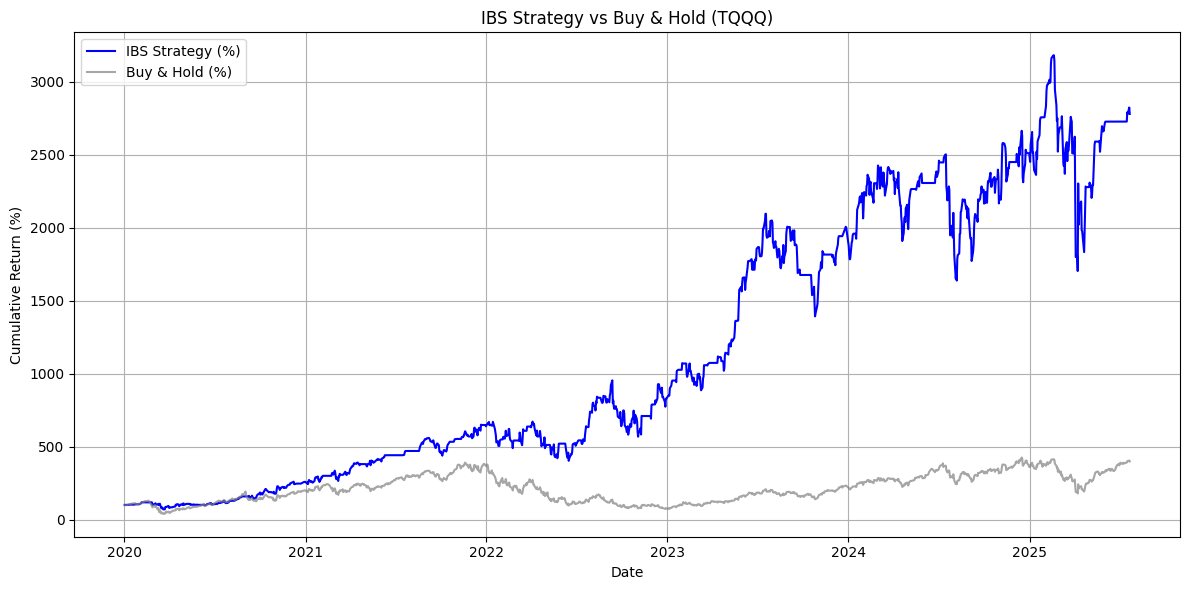

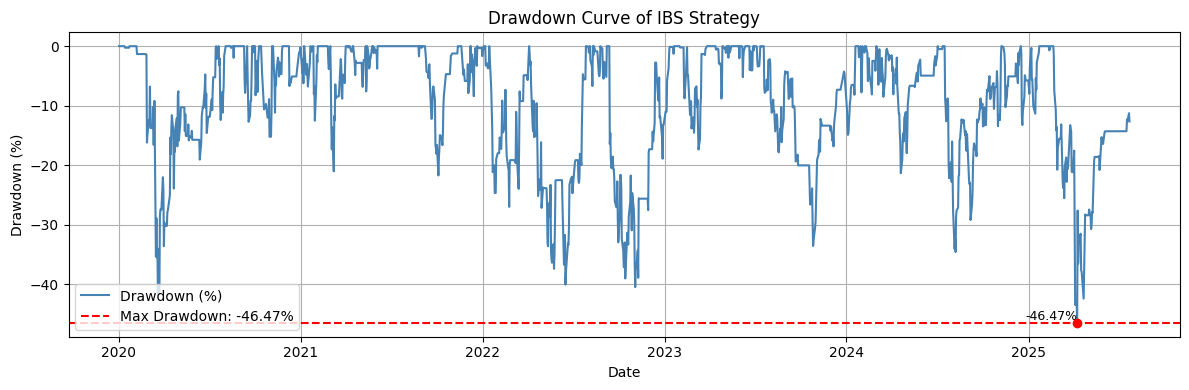

In [ ]:
sharpe, total_return, max_drawdown, win_rate, data = IBS_strategy(data, entry_threshold, exit_threshold, initial_capital, initial_cash, initial_shares)
# Strategy return = daily % change in total capital
data["Strategy Return"] = data["Capital"].pct_change()

# Cumulative return from compounded capital (already in Capital, so optional)
data["Cumulative Strategy"] = data["Capital"] / data["Capital"].iloc[0]

# Market return remains unchanged (buy and hold benchmark)
data["Market Return"] = data[("Close", ticker)].pct_change()
data["Cumulative Market"] = (1 + data["Market Return"]).cumprod()

# Max drawdown from capital-based strategy
cumulative_max = data["Cumulative Strategy"].cummax()
drawdown = (data["Cumulative Strategy"] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()
print(f"Max Drawdown: {max_drawdown:.2%}")

# Plot performance

fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary axis (left): Cumulative returns
ax1.plot(data.index, data["Cumulative Strategy"] * 100, label="IBS Strategy (%)", color="blue")
ax1.plot(data.index, data["Cumulative Market"] * 100, label="Buy & Hold (%)", color="gray", alpha=0.7)
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative Return (%)")
ax1.grid(True)
'''
# Create secondary y-axis
ax2 = ax1.twinx()
ax2.plot(data.index, data["Capital"] / 1000, label="Capital ($K)", color="green", alpha=0.6)
ax2.set_ylabel("Capital (in thousands)")
'''
# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc="upper left")

# Final styling
plt.title(f"IBS Strategy vs Buy & Hold ({ticker})")
plt.tight_layout()
plt.show()

max_dd_date = drawdown.idxmin()

plt.figure(figsize=(12, 4))
plt.plot(data.index, drawdown * 100, label="Drawdown (%)", color="steelblue")
plt.axhline(max_drawdown * 100, color="red", linestyle="--", label=f"Max Drawdown: {max_drawdown:.2%}")
plt.scatter(max_dd_date, max_drawdown * 100, color="red", zorder=5)
plt.text(max_dd_date, max_drawdown * 100, f"{max_drawdown:.2%}", va='bottom', ha='right', fontsize=9)
plt.title("Drawdown Curve of IBS Strategy")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# print(data.head(10))

# Sharpe Ratio, Total Returns and Win Rate


In [ ]:
print(f"Sharpe Ratio: {sharpe:.3}")
print(f"Total Returns: {total_return:.2%}")
print(f"Win Rate: {win_rate:.2%}")

Sharpe Ratio: 1.28
Total Returns: 2678.26%
Win Rate: 70.45%


# Backtesting/Optimization

In [ ]:
# --- Optimization Loop ---

entry_vals = np.arange(0.01, 0.20, 0.02)
exit_vals = np.arange(0.81, 1.00, 0.02)
# entry and exit are fixed at <0.2 and >0.8 based on the intuition of IBS

notebook_results = []

# if testing both entry and exit
'''
for entry in entry_vals:
    for exit in exit_vals:
        sharpe, total_return, max_drawdown, win_rate, _ = IBS_strategy(data, entry, exit, initial_capital, initial_cash, initial_shares)
        cumulative_return_pct = total_return * 100
        max_drawdown_pct = max_drawdown * 100
        win_rate_pct = win_rate * 100
        notebook_results.append({
                "Entry": entry,
                "Exit": exit,
                "Sharpe": sharpe,
                "Max Drawdown": max_drawdown_pct,
                "Win Rate": win_rate_pct,
                "Total Return (%)": cumulative_return_pct
        })
'''

# if testing entry only, fix exit at 0.95
exit = 0.95
for entry in entry_vals:
    sharpe, total_return, max_drawdown, win_rate, _ = IBS_strategy(data, entry, exit, initial_capital, initial_cash, initial_shares)
    cumulative_return_pct = total_return * 100
    max_drawdown_pct = max_drawdown * 100
    win_rate_pct = win_rate * 100
    notebook_results.append({
              "Entry": entry,
              "Exit": exit,
              "Sharpe": sharpe,
              "Max Drawdown": max_drawdown_pct,
              "Win Rate": win_rate_pct,
              "Total Return (%)": cumulative_return_pct
        })


notebook_results_df = pd.DataFrame(notebook_results)
notebook_results_sorted = notebook_results_df.sort_values(by=["Total Return (%)", "Sharpe"], ascending=False)
notebook_results_sorted.head(10)
# Eval here is done prioritising total return, but you can use other matrices
# entry and exit of 0.19 and 0.95 maximises overall returns for TQQQ (2020-2025) at 2678.26%, sharpe ratio of 1.28, max drawdown of 46.47%, win rate of 70.45%
# entry and exit of 0.07 and 0.95 maximises overall returns for SPXL (2020-2025) at 1002.96%, sharpe ratio of 1.19, max drawdown of 37.27%, win rate of 70.97%
# fixing exit at 0.95 and optimising entry in the 0.05-0.2 range works well
# Feel free to experiment with other tickers and timeframes

,Entry,Exit,Sharpe,Max Drawdown,Win Rate,Total Return (%)
9,0.19,0.95,1.283279,-46.474135,70.454545,2678.264071
8,0.17,0.95,1.211415,-46.478545,70.238095,1956.529790
6,0.13,0.95,1.198507,-40.769922,68.000000,1750.814294
5,0.11,0.95,1.189264,-39.969344,68.656716,1605.319469
7,0.15,0.95,1.162651,-47.502889,69.620253,1588.381592
4,0.09,0.95,1.134529,-39.969344,67.213115,1294.501963
3,0.07,0.95,1.066211,-38.826293,65.384615,888.998503
2,0.05,0.95,1.046271,-35.807696,68.085106,793.700258
1,0.03,0.95,0.832943,-35.807696,72.727273,332.199220
0,0.01,0.95,0.329047,-28.330327,57.142857,28.646635


# Buy or Sell your stock based on IBS signal?
*    Use this block of code to check whether there is a buy/sell signal using the IBS indicator

/tmp/ipython-input-45-1392121356.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed



IBS value on 2025-07-22: 0.457
⏸ No action


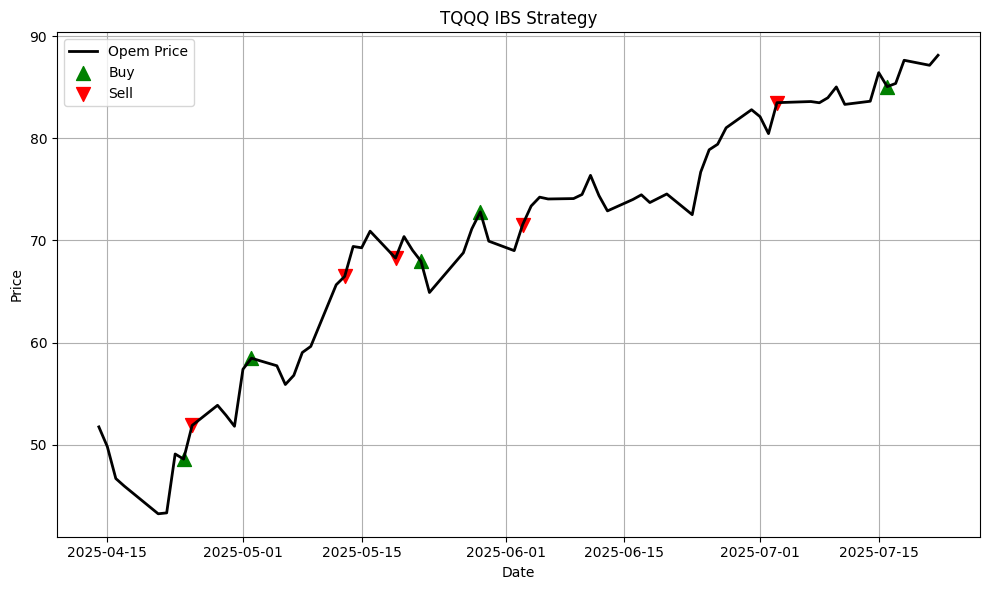

Price,Date,Close,High,Low,Open,Volume,IBS,Signal
Ticker,,TQQQ,TQQQ,TQQQ,TQQQ,TQQQ,,
0,2025-04-14,49.461552,51.904714,47.935824,51.755135,147430700,0.384422,Hold
1,2025-04-15,49.651024,51.067058,49.052696,49.820548,104670100,0.297031,Hold
2,2025-04-16,45.163582,47.875987,43.039526,46.699284,134574400,0.439176,Hold
3,2025-04-17,45.033947,46.160794,44.226207,45.961351,101095800,0.417526,Hold
4,2025-04-21,41.743156,43.518187,40.127679,43.248940,114769700,0.476471,Hold
...,...,...,...,...,...,...,...,...
63,2025-07-16,85.070000,85.349998,82.440002,85.059998,83178800,0.903780,Buy
64,2025-07-17,87.050003,87.320000,85.000000,85.370003,48665400,0.883622,Hold
65,2025-07-18,86.750000,87.739998,86.190002,87.639999,49248100,0.361290,Hold


In [45]:
from datetime import datetime, timedelta
import pytz

# Check whether to enter or exit a position based on the IBS strategy.

ticker = "TQQQ"
entry_threshold = 0.19
exit_threshold = 0.95

def enter_position(ticker, entry_threshold, exit_threshold, lookback_days=100):
    """
    Args:
        ticker (str): Ticker symbol (e.g. "TQQQ")
        entry_threshold (float): IBS entry threshold
        exit_threshold (float): IBS exit threshold
        lookback_days (int): Number of days to fetch from yfinance (default: 100)
    """

    # Get current US Eastern time
    us_eastern = pytz.timezone("America/New_York")
    now_us = datetime.now(us_eastern)
    start_date = (now_us - timedelta(days=lookback_days)).strftime("%Y-%m-%d")
    end_date = now_us.strftime("%Y-%m-%d")

    # Download historical data
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty or len(data) < 2:
        print()
        print("Not enough data to evaluate.")
        return data

    # Reset index and compute IBS
    data = data.reset_index()
    data["IBS"] = (data["Close"] - data["Low"]) / (data["High"] - data["Low"])

    # Initialize Signal column
    data["Signal"] = "Hold"

    # Assign Buy/Sell signals based on previous day's IBS
    for i in range(1, len(data)):
        prev_ibs = data["IBS"].iloc[i - 1]

        if prev_ibs < entry_threshold:
            data.at[i, "Signal"] = "Buy"
        elif prev_ibs > exit_threshold:
            data.at[i, "Signal"] = "Sell"
        else:
            data.at[i, "Signal"] = "Hold"

    # Determine which row to check (latest or second latest)
    last_date_str = data["Date"].iloc[-1].strftime("%Y-%m-%d")
    check_row = -2 if last_date_str == end_date else -1

    # Trading signals
    ibs_value = data["IBS"].iloc[check_row]
    print()
    print(f"IBS value on {data['Date'].iloc[check_row].date()}: {ibs_value:.3f}")

    if ibs_value < entry_threshold:
        print("📈 Buy signal")
    elif ibs_value > exit_threshold:
        print("📉 Sell signal")
    else:
        print("⏸ No action")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(data["Date"], data["Open"], label="Opem Price", color='black', linewidth=2)

    # Buy signals
    buy_signals = data[data["Signal"] == "Buy"]
    plt.scatter(buy_signals["Date"], buy_signals["Open"], color="green", label="Buy", marker="^", s=100)

    # Sell signals
    sell_signals = data[data["Signal"] == "Sell"]
    plt.scatter(sell_signals["Date"], sell_signals["Open"], color="red", label="Sell", marker="v", s=100)

    plt.title(f"{ticker} IBS Strategy")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return data   # pd.DataFrame: Data with IBS column

enter_position(ticker, entry_threshold, exit_threshold)